In [40]:
%matplotlib widget

In [41]:
import sys
sys.path.append('../external/tslib')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import os
import json
import time
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Simulator implementation

In [3]:
from dataclasses import dataclass, field
from typing import List, Optional


@dataclass
class Task:
    id: str
    request_time: int
    duration: int
    start_time: Optional[int] = None
    end_time: Optional[int] = None
    assigned_worker: Optional[str] = None

    def __str__(self):
        return f"Task({self.id}|{self.duration}ms|{self.assigned_worker}|{self.request_time}-{self.start_time}-{self.end_time})"

@dataclass
class MetricsDataPoint:
    time: int = 0
    expected_workers: int = 0
    active_workers: int = 0
    total_workers: int = 0
    num_new_tasks: int = 0
    num_ongoing_tasks: int = 0
    num_queued_tasks: int = 0
    num_completed_tasks: int = 0
    avg_delay: float = 0.0
    avg_duration: float = 0.0
    reward: float = 0.0
    completed_tasks: List['Task'] = field(default_factory=list)
    
def generate_reward_function(metrics_window: float, value_per_task: float = 0.001, cost_per_worker_hour: float = 1, delay_threshold: int = 8000) -> float:
    # Example reward function: negative of average delay
    return lambda metrics: (
        sum([0 if (task.end_time - task.request_time) > delay_threshold else value_per_task for task in metrics.completed_tasks]) -
        cost_per_worker_hour * (metrics.total_workers * metrics_window / 3600000 )
    )

class Worker:
    def __init__(self, init_time: int = 0):
        self.id = "worker-" + str(random.randint(0, 10000))
        self.available_at = init_time
        self.active = False  # 是否已经初始化完成

    def assign_task(self, task: Task, current_time: int):
        if current_time < self.available_at:
            task.start_time = self.available_at
            self.available_at += task.duration
        else:
            task.start_time = current_time
            self.available_at = current_time + task.duration
        task.end_time = self.available_at
        task.assigned_worker = self.id
    
    def is_available(self, current_time: int) -> bool:
        return self.available_at <= current_time and self.active
    


class Simulator:
    def __init__(self, tasks: List[Task], init_workers: int = 1, worker_init_time_min : int = 12000, worker_init_time_max : int = 12000, metrics_window: int = 10000, reward_function=None):
        self.tasks = sorted(tasks, key=lambda t: t.request_time)
        self.time = 0  
        self.metrics_window = metrics_window
        self.worker_init_time_min = worker_init_time_min
        self.worker_init_time_max = worker_init_time_max
        self.expected_workers = init_workers
        self.workers = [Worker(self.__get_worker_init_time()) for i in range(init_workers)]
        self.terminating_workers: List[Task] = []
        self.in_progress: List[Task] = []
        self.queued: List[Task] = []
        self.completed_tasks: List[Task] = []

        self.new_tasks = 0
        self.metrics: List[MetricsDataPoint] = []
        self.reward_function = reward_function

    def tick(self): # tick 1s
        self.time += 1000
        # check completed tasks
        for task in self.in_progress:
            if task.end_time <= self.time:
                self.completed_tasks.append(task)
                self.in_progress.remove(task)
        # check initialized workers
        for w in self.workers:
            if not w.active and self.time >= w.available_at:
                w.active = True
        # check terminating workers
        self.terminating_workers = [w for w in self.terminating_workers if w.available_at >= self.time]
        
        worker = self.__get_available_worker(self.time)
        # pop queued tasks
        while worker and self.queued:
            task = self.queued.pop(0)
            worker.assign_task(task, task.request_time)
            self.in_progress.append(task)
            worker = self.__get_available_worker(self.time)
        # pop new tasks
        while self.tasks and self.tasks[0].request_time < self.time:
            task = self.tasks.pop(0)
            self.new_tasks += 1
            if worker:
                worker.assign_task(task, self.time)
                self.in_progress.append(task)
                worker = self.__get_available_worker(self.time)
            else:
                self.queued.append(task)
        # report metrics
        if self.time % self.metrics_window == 0:
            self.report_metrics()

    def scale(self, expected_workers: int):
        if expected_workers > self.expected_workers:
            for _ in range(expected_workers - self.expected_workers):
                worker = Worker(self.time + self.__get_worker_init_time())
                self.workers.append(worker)
        elif expected_workers < self.expected_workers:
            for _ in range(self.expected_workers - expected_workers):
                for w in self.workers:
                    if not w.active:
                        worker = w
                        self.workers.remove(worker)
                        break
                else:
                    worker = self.workers.pop()
                self.terminating_workers.append(worker)
        self.expected_workers = expected_workers

    def report_metrics(self):
        if self.completed_tasks:
            avg_delay = int(np.mean([t.end_time - t.request_time for t in self.completed_tasks]))
            avg_duration = int(np.mean([t.end_time - t.start_time for t in self.completed_tasks]))
        else:
            avg_delay = 0
            avg_duration = 0
        dataPoint = MetricsDataPoint(
            time=self.time,
            expected_workers=self.expected_workers,
            active_workers=len([w for w in self.workers if w.active]),
            total_workers=len(self.workers) + len(self.terminating_workers),
            num_new_tasks=self.new_tasks,
            num_ongoing_tasks=len(self.in_progress) + len(self.queued),
            num_queued_tasks=len(self.queued),
            num_completed_tasks=len(self.completed_tasks),
            avg_delay=avg_delay,
            avg_duration=avg_duration,
            completed_tasks=self.completed_tasks.copy(),
            reward=0,  # Placeholder for reward, to be calculated later
        )
        if self.reward_function:
            dataPoint.reward = self.reward_function(dataPoint)
        self.metrics.append(dataPoint)
        self.completed_tasks.clear()
        self.new_tasks = 0
        
    def plot_metrics(self, tmp_output_dir: str = None):
        metric_keys = [
            'expected_workers',
            'active_workers',
            'total_workers',
            'num_new_tasks',
            'num_ongoing_tasks',
            'num_queued_tasks',
            'num_completed_tasks',
            'avg_delay',
            'avg_duration',
            'reward'
        ]

        data = {key: [] for key in metric_keys}
        time_s = [int(m.time / 1000) for m in self.metrics]

        for metrics in self.metrics:
            for key in metric_keys:
                data[key].append(getattr(metrics, key))

        fig, axes = plt.subplots(len(metric_keys), 1, figsize=(14, 20), sharex=True)

        for ax, key in zip(axes, metric_keys):
            ax.plot(time_s, data[key], label=key)
            ax.set_ylabel(key)
            ax.grid(True)
            ax.legend(loc='upper left')

        axes[-1].set_xlabel("Time (s)")
        fig.tight_layout()
        if tmp_output_dir:
            plt.savefig(os.path.join(tmp_output_dir, "metrics_plot.png"), dpi=300)
        else:
            plt.show()

    def __get_available_worker(self, current_time: int) ->Optional[Worker]:
        # FIFO
        available_worker, min_available_at = None, float('inf')
        for worker in self.workers:
            if worker.is_available(current_time) and worker.available_at < min_available_at:
                min_available_at = worker.available_at
                available_worker = worker
        return available_worker
    
    def __get_worker_init_time(self) -> int:
        return random.randint(self.worker_init_time_min, self.worker_init_time_max)


### Test cases generation

In [4]:
from datetime import timedelta

def extract_continuous_segment(df, week_count, day_count, time_scale, request_scale):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 设置时间戳为索引
    df.set_index('timestamp', inplace=True)

    # 获取数据的起始和结束时间
    start_time = df.index.min()
    end_time = df.index.max()

    # 计算所需的总天数
    total_days = week_count * 7 + day_count

    # 查找所有满足条件的连续时间段
    valid_starts = []
    if week_count > 0:
        # 计算所有可能的周一 00:00 的时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='W-MON')
    else:
        # 计算所有可能的起始时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='D')

    if valid_starts.empty:
        print("❌ 数据中没有满足条件的连续时间段。")
        return

    # 随机选择一个起始时间
    selected_start = random.choice(valid_starts)
    selected_end = selected_start + timedelta(days=total_days)
    print(f"✅ 选中的时间段：{selected_start} 到 {selected_end}")

    # 提取选中的数据段
    segment = df.loc[selected_start:selected_end].copy()
    if segment.empty:
        print("⚠️ 选中的时间段内没有数据。")
        return

    # 重置时间戳，从 0 开始，并应用时间缩放
    segment.reset_index(inplace=True)
    base_time = segment['timestamp'].min()
    segment['timestamp'] = segment['timestamp'].apply(lambda x: int((x - base_time).total_seconds() / time_scale))

    # 应用请求数缩放
    segment['requests'] = segment['requests'] / request_scale

    return segment[['timestamp', 'requests']].reset_index(drop=True), base_time

def schedule_requests_from_csv(requests_df, rate_df):
    # 打乱请求顺序
    requests_df = requests_df.sample(frac=1).reset_index(drop=True)

    result_rows = []
    request_index = 0
    accum = 0.0  # 累积速率

    for _, rate_row in rate_df.iterrows():
        timestamp_base = float(rate_row['timestamp'])
        rps = float(rate_row['requests'])

        accum += rps
        num_requests = int(accum)
        accum -= num_requests  # 保留小数部分

        for _ in range(num_requests):
            if request_index >= len(requests_df):
                break
            row = requests_df.iloc[request_index].copy()
            # 在[T, T+1)内均匀分布]
            row['timestamp'] = timestamp_base + random.uniform(0, 1)
            result_rows.append(row)
            request_index += 1

        if request_index >= len(requests_df):
            break
    
    # sort by timestamp
    result_rows.sort(key=lambda x: x['timestamp'])

    # 创建结果 DataFrame
    return pd.DataFrame(result_rows, columns=['Id', 'Duration', 'timestamp']).rename(columns={'Id': 'id', 'Duration': 'duration'})

def generate_tasks_from_csv(requests_csv_path, rate_csv_path, week_count=0, day_count=3, scale = 0.8):
    # 读取请求数据
    requests_df = pd.read_csv(requests_csv_path)
    rate_df = pd.read_csv(rate_csv_path)

    # 提取连续时间段
    segment, base_time = extract_continuous_segment(rate_df, week_count, day_count, 120, 120 * 1 / scale)
    if segment is None:
        return None
    
    tasks_df = schedule_requests_from_csv(requests_df, segment)
    if tasks_df is None:
        return None
    
    time_start = tasks_df['timestamp'].min() 
    tasks_df['timestamp'] = tasks_df['timestamp'].apply(lambda x: int((x - time_start) * 1000))  # 转换为毫秒
    tasks_df['id'] = tasks_df['id'].astype(int)
    tasks_df['duration'] = tasks_df['duration'].astype(int)


    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    return tasks, base_time

def save_metrics_to_csv(metric_history, output_path):
    # Build DataFrame
    df = pd.DataFrame(metric_history)
    df['time'] = df['time'].apply(lambda x: int(x / 1000)) 
    df['reward'] = df['reward'].apply(lambda x: round(x, 4))
    df['completed_tasks'] = df['completed_tasks'].apply(lambda x: ','.join([f"Task({t['id']}|{t['duration']}ms|{t['assigned_worker']}|{t['request_time']}-{t['start_time']}-{t['end_time']})" for t in x]))

    # Write to CSV
    out_path = os.path.join(output_path)
    df.to_csv(out_path, index=False)
    print(f"✅ 生成的指标数据已保存到 {out_path}")
    

### Environement settings & parameters

In [5]:
day_count = 3
scale = 1.5
request_mean = 3.69341263 * scale
request_std = 2.05966675 * scale
iterations = 60 * 12 * day_count
init_workers = 1
min_workers = 1
max_workers = 6
worker_init_time_min = 40
worker_init_time_max = 40
metrics_window = 10
forecast_window = 36
observe_length = 3
future_length = 12
reward_function = generate_reward_function(metrics_window * 1000, value_per_task=0.002, cost_per_worker_hour=1, delay_threshold=8000)

In [6]:
test_set_size = 20

test_set = [
    generate_tasks_from_csv(
            requests_csv_path='../data/test_regression_clipped.csv',
            rate_csv_path='../data/request_timeseries_test.csv',
            week_count=0,
            day_count=day_count,
            scale=scale,
    ) for i in range (test_set_size)
] 

✅ 选中的时间段：2025-03-18 17:48:00+00:00 到 2025-03-21 17:48:00+00:00
✅ 选中的时间段：2025-03-25 17:48:00+00:00 到 2025-03-28 17:48:00+00:00
✅ 选中的时间段：2025-03-21 17:48:00+00:00 到 2025-03-24 17:48:00+00:00
✅ 选中的时间段：2025-03-23 17:48:00+00:00 到 2025-03-26 17:48:00+00:00
✅ 选中的时间段：2025-03-17 17:48:00+00:00 到 2025-03-20 17:48:00+00:00
✅ 选中的时间段：2025-03-17 17:48:00+00:00 到 2025-03-20 17:48:00+00:00
✅ 选中的时间段：2025-03-16 17:48:00+00:00 到 2025-03-19 17:48:00+00:00
✅ 选中的时间段：2025-03-21 17:48:00+00:00 到 2025-03-24 17:48:00+00:00
✅ 选中的时间段：2025-03-16 17:48:00+00:00 到 2025-03-19 17:48:00+00:00
✅ 选中的时间段：2025-03-20 17:48:00+00:00 到 2025-03-23 17:48:00+00:00
✅ 选中的时间段：2025-03-18 17:48:00+00:00 到 2025-03-21 17:48:00+00:00
✅ 选中的时间段：2025-03-16 17:48:00+00:00 到 2025-03-19 17:48:00+00:00
✅ 选中的时间段：2025-03-23 17:48:00+00:00 到 2025-03-26 17:48:00+00:00
✅ 选中的时间段：2025-03-18 17:48:00+00:00 到 2025-03-21 17:48:00+00:00
✅ 选中的时间段：2025-03-27 17:48:00+00:00 到 2025-03-30 17:48:00+00:00
✅ 选中的时间段：2025-03-27 17:48:00+00:00 到 2025-03-30 17:48:0

### Threshold based scaling baseline

In [7]:
class ThresholdBasedStrategy:
    def __init__(self, 
                 min_workers: int = min_workers,
                 max_workers: int = max_workers,
                 aggressive_scale: bool = False,
                 target_ongoing_tasks: int = 3, 
                 scale_up_window: int = 1, 
                 scale_down_window: int = 1):
        self.min_workers = min_workers
        self.max_workers = max_workers
        self.aggressive_scale = aggressive_scale
        self.target_ongoing_tasks = target_ongoing_tasks
        self.scale_up_window = scale_up_window
        self.scale_down_window = scale_down_window

    def calc(self, current_expected_workers: int, metrics: List[MetricsDataPoint]) -> int:
        if len(metrics) < self.scale_up_window or len(metrics) < self.scale_down_window:
            return current_expected_workers
        # Calculate the average number of ongoing tasks over the last scale_up_window iterations
        avg_ongoing_tasks_up = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_up_window:]])
        # Calculate the average number of ongoing tasks over the last scale_down_window iterations
        avg_ongoing_tasks_down = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_down_window:]])
        # Scale up if the average number of ongoing tasks is greater than the target
        new_workers = current_expected_workers
        running_workers = max(1, metrics[-1].active_workers)
        if avg_ongoing_tasks_up > self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_up / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers > current_expected_workers:
                new_workers = current_expected_workers + 1
            new_workers = min(new_workers, self.max_workers)

        if avg_ongoing_tasks_down < self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_down / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers < current_expected_workers:
                new_workers = current_expected_workers - 1
            new_workers = max(new_workers, self.min_workers)

        return int(new_workers)

In [13]:
def eval_threshold_based(target_value):
    os.makedirs(f'rl/result/simulation/threshold_{target_value}', exist_ok=True)
    strategy = ThresholdBasedStrategy(
        min_workers=min_workers,
        max_workers=max_workers,
        aggressive_scale=True,
        target_ongoing_tasks=target_value,
        scale_up_window=1,
        scale_down_window=1
    )
    for idx, (tasks, base_time) in enumerate(test_set):
        simulator = Simulator(tasks, init_workers, worker_init_time_min * 1000, worker_init_time_max * 1000, metrics_window * 1000,
                            reward_function=reward_function
        )
        for i in range(iterations):
            simulator.tick()
            if i > 0 and i % metrics_window == 0:
                expected_workers = strategy.calc(simulator.expected_workers, simulator.metrics)
                simulator.scale(expected_workers)
        print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
        save_metrics_to_csv(simulator.metrics, f'rl/result/simulation/threshold_{target_value}/test_{idx}.csv')

In [14]:
eval_threshold_based(3)

🤩 总reward为： 0.37044444444444474
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_0.csv
🤩 总reward为： 0.3384444444444451
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_1.csv
🤩 总reward为： 0.3220000000000006
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_2.csv
🤩 总reward为： 0.5262222222222234
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_3.csv
🤩 总reward为： 0.20888888888888885
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_4.csv
🤩 总reward为： 0.19866666666666696
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_5.csv
🤩 总reward为： 0.10344444444444442
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_6.csv
🤩 总reward为： 0.44044444444444525
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_7.csv
🤩 总reward为： 0.011000000000000003
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_8.csv
🤩 总reward为： 0.5552222222222226
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_9.csv
🤩 总reward为： 0.3316666666666667
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_3/test_10.csv
🤩 总reward为： 0

In [15]:
eval_threshold_based(4)

🤩 总reward为： 0.583555555555556
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_0.csv
🤩 总reward为： 0.35877777777777853
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_1.csv
🤩 总reward为： 0.4996666666666673
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_2.csv
🤩 总reward为： 0.47788888888888936
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_3.csv
🤩 总reward为： 0.4586666666666668
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_4.csv
🤩 总reward为： 0.30755555555555586
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_5.csv
🤩 总reward为： 0.24411111111111133
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_6.csv
🤩 总reward为： 0.4890000000000006
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_7.csv
🤩 总reward为： 0.1357777777777778
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_8.csv
🤩 总reward为： 0.3337777777777781
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_9.csv
🤩 总reward为： 0.5187777777777779
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_4/test_10.csv
🤩 总reward为： 0.278

In [16]:
eval_threshold_based(5)

🤩 总reward为： 0.5484444444444445
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_0.csv
🤩 总reward为： 0.35555555555555596
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_1.csv
🤩 总reward为： 0.20955555555555586
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_2.csv
🤩 总reward为： 0.31611111111111156
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_3.csv
🤩 总reward为： 0.27466666666666667
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_4.csv
🤩 总reward为： 0.18200000000000008
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_5.csv
🤩 总reward为： 0.16022222222222227
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_6.csv
🤩 总reward为： 0.11977777777777796
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_7.csv
🤩 总reward为： 0.05688888888888893
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_8.csv
🤩 总reward为： 0.36000000000000026
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_9.csv
🤩 总reward为： 0.5007777777777777
✅ 生成的指标数据已保存到 rl/result/simulation/threshold_5/test_10.csv
🤩 总reward为：

### RL based scaling 

In [ ]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from lib.forecast.tslib_util import (
    TimeseriesForecaster,
    TimeseriesTransformer
)

class WorkerScaling(gym.Env):

    FEATURE_MIN = {
        "running_workers": 0,
        "new_requests": 0,
        "ongoing_requests": 0,
        "finished_requests": 0,
        "requests_delay": 0.0,
        "requests_duration": 0.0,
        "forecasted_requests": 0.0,
    }

    FEATURE_MAX = {
        "running_workers": max_workers,         
        "new_requests": scale * 10,            
        "ongoing_requests": scale * 50,        
        "finished_requests": max_workers * 6,       
        "requests_delay": scale * 20000,          
        "requests_duration": 12000, 
        "forecasted_requests": scale * 10,      
    }

    def __init__(self, config: Optional[dict] = None):
        self.config = config or {}
        self.observe_length = self.config.get("observe_length", 36)
        self.future_length = self.config.get("future_length", 36)
        self.action_space = Discrete(max_workers)
        self.observation_space = Box(0.0, 1.0, shape=(self.observe_length * 6 + self.future_length,), dtype=np.float32)
        self.time_s = 0

        self.forecaster = TimeseriesForecaster()

        random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)
        np.random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)


    def reset(self, *, seed=None, options=None):
        self.init_simulator()
        # Return obs and (empty) info dict.
        return self.extract_observation_window(self.simulator.metrics), {"env_state": "reset"}

    def step(self, action):
        assert action in range(max_workers), f"Invalid action {action}"
        
        self.simulator.scale(action + min_workers)
        for _ in range(metrics_window):
            self.simulator.tick()
            self.time_s += 1
            if self.time_s >= iterations:
                break

        terminated = self.time_s >= iterations
        truncated = False


        reward = self.simulator.metrics[-1].reward
        infos = {}
        return (
            self.extract_observation_window(self.simulator.metrics),
            reward,
            terminated,
            truncated,
            infos,
        )
    
    def init_simulator(self, tasks=None, base_time=None):
        if tasks is None:
            tasks, base_time = generate_tasks_from_csv(
                requests_csv_path='../data/train_regression_clipped.csv',
                rate_csv_path='../data/request_timeseries_train.csv',
                week_count=0,
                day_count=day_count,
                scale=scale,
            )
        self.simulator = Simulator(tasks, 1, worker_init_time_min* 1000, worker_init_time_max *1000, metrics_window * 1000, reward_function)

        self.forecaster.setTransformer(
            transformer=TimeseriesTransformer(
                date_start=base_time.timestamp(), date_scale=120, scale=True,
                scale_mean=request_mean, scale_std=request_std
            )
        )
        self.time_s = 0
        self.iteration = 0
        self.max_iterations = len(tasks) * 2

    
    def extract_observation_window(self, data: List[MetricsDataPoint]) -> np.ndarray:

        # get forecasted data

        obs = np.zeros((self.observe_length * 6 + self.future_length,), dtype=np.float32)
        if len(data) == 0:
            return obs

        if len(data) >= forecast_window:
            forecast_metrics =  data[-forecast_window:]
            recent_new_request = [0 if not m else m.num_new_tasks for m in forecast_metrics]
            recent_timestamp = [self.time_s - i * metrics_window for i in range(forecast_window-1, -1, -1)]
            future_requests = self.forecaster.forecast(
                enc_data=recent_new_request,
                enc_stamp=recent_timestamp,
            )[:self.future_length]
        else:
            future_requests = np.zeros(self.future_length, dtype=np.float32)

        # print(f"Recent requests:{recent_new_request} \n---\n Forecasted future requests: {future_requests}")

        recent = data[-self.observe_length:] if len(data) >= self.observe_length else [None] * (self.observe_length - len(data)) + data
        for i, point in enumerate(recent + list(future_requests)):
            if point is None:
                continue  # Keep default zeros for padding

            observed = isinstance(point, MetricsDataPoint)
            features = [
                ("running_workers", point.active_workers),
                ("requests_delay", point.avg_delay),
                ("requests_duration", point.avg_duration),
                ("ongoing_requests", point.num_ongoing_tasks),
                ("finished_requests", point.num_completed_tasks),
                ("new_requests", point.num_new_tasks)
            ] if observed else [
                ("new_requests", point)
            ]

            for row, (key, raw_value) in enumerate(features):
                min_val = WorkerScaling.FEATURE_MIN[key]
                max_val = WorkerScaling.FEATURE_MAX[key]
                # Min-max normalization with small epsilon for safety
                norm_val = (raw_value - min_val) / (max_val - min_val + 1e-6)
                norm_val = np.clip(norm_val, 0.0, 1.0)
                if i < self.observe_length:
                    obs[row * self.observe_length + i] = norm_val
                else:
                    obs[6 * self.observe_length + i - self.observe_length] = norm_val

        return obs

In [30]:
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.utils.numpy import convert_to_numpy, softmax

rl_module = RLModule.from_checkpoint(
    os.path.join(
        '/home/ypp/ray_results/PPO_2025-06-26_02-43-11/PPO_WorkerScaling_3efe5_00000_0_2025-06-26_02-43-12/checkpoint_000015',
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )
)

def eval_rl_based():
    os.makedirs('rl/result/simulation/rl', exist_ok=True)
    env = WorkerScaling(config={"observe_length": observe_length, "future_length": future_length,})
    for idx, (tasks, base_time) in enumerate(test_set):
        env.init_simulator(tasks, base_time)
        simulator = env.simulator

        action = init_workers - min_workers
        while True:
            obs, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break
            input_dict = {Columns.OBS: torch.from_numpy(obs).unsqueeze(0)}
            rl_module_out = rl_module.forward_inference(input_dict)
            logits = convert_to_numpy(rl_module_out[Columns.ACTION_DIST_INPUTS])
            # get action with the largest probability
            action = np.argmax(logits[0])

        print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
        save_metrics_to_csv(simulator.metrics, f'rl/result/simulation/rl/test_{idx}.csv')

In [31]:
eval_rl_based()

Using cpu or mps
Use CPU
🤩 总reward为： 0.6718888888888899
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_0.csv
🤩 总reward为： 0.8801111111111135
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_1.csv
🤩 总reward为： 0.6647777777777796
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_2.csv
🤩 总reward为： 0.8476666666666686
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_3.csv
🤩 总reward为： 0.5211111111111112
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_4.csv
🤩 总reward为： 0.5386666666666667
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_5.csv
🤩 总reward为： 0.48822222222222234
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_6.csv
🤩 总reward为： 0.9895555555555584
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_7.csv
🤩 总reward为： 0.51
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_8.csv
🤩 总reward为： 0.9284444444444468
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_9.csv
🤩 总reward为： 0.7121111111111125
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_10.csv
🤩 总reward为： 0.528
✅ 生成的指标数据已保存到 rl/result/simulation/rl/test_11.csv
🤩 总reward为： 0.974111111111114
✅ 生成的指标数据

### Result comparison

In [43]:
model_dirs = ['rl/result/simulation/rl', 'rl/result/simulation/threshold_3', 'rl/result/simulation/threshold_4', 'rl/result/simulation/threshold_5']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['RL+forecast', 'Threshold = 3', 'Threshold = 4', 'Threshold = 5']

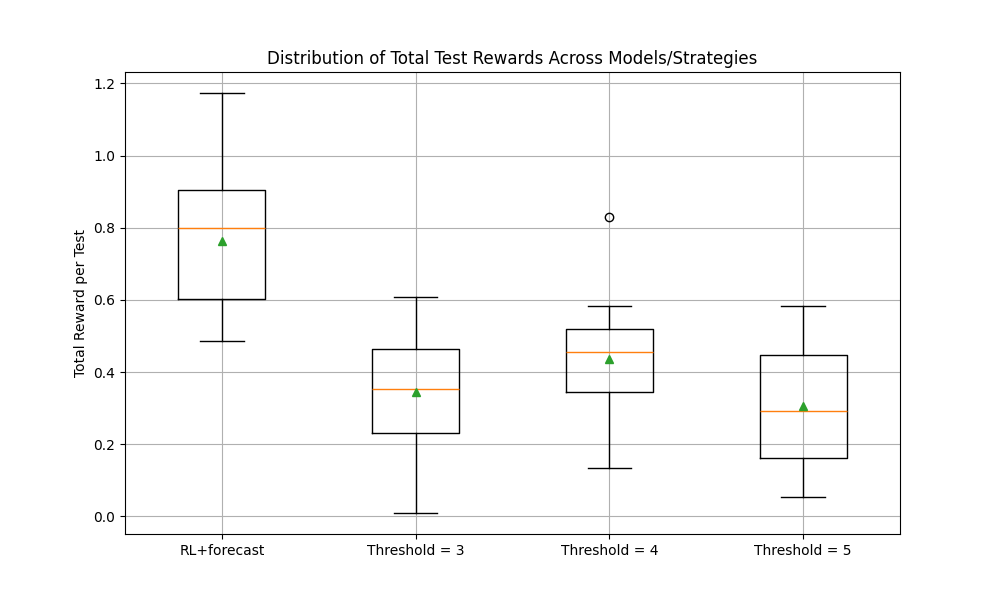

In [55]:
reward_sums = {}

# 遍历每个模型
for model in model_dirs:
    sums = []
    for i in range(20):
        file_path = os.path.join(model, f'test_{i}.csv')
        df = pd.read_csv(file_path)
        # 去除空值（最后一列completed_tasks似乎缺值）
        rewards = pd.to_numeric(df['reward'], errors='coerce').dropna()
        sums.append(rewards.sum())
    reward_sums[model] = sums

# 画箱型图（Box Plot）
plt.figure(figsize=(10, 6))
plt.boxplot([reward_sums[m] for m in model_dirs], labels=labels, showmeans=True)
plt.ylabel('Total Reward per Test')
plt.title('Distribution of Total Test Rewards Across Models/Strategies')
plt.grid(True)
plt.show()

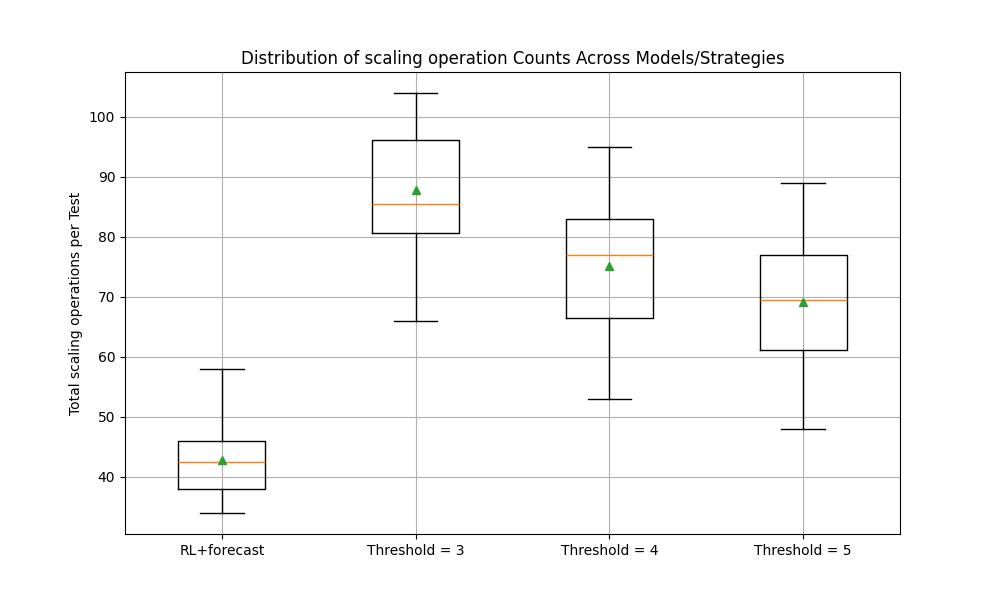

In [56]:
change_counts = {}

for model in model_dirs:
    changes = []
    for i in range(20):
        file_path = os.path.join(model, f'test_{i}.csv')
        df = pd.read_csv(file_path)
        workers = pd.to_numeric(df['expected_workers'], errors='coerce').dropna()
        diff = (workers != workers.shift(1)).sum() - 1  # 减1排除首个值
        changes.append(diff)
    change_counts[model] = changes

# 可视化：箱型图
plt.figure(figsize=(10, 6))
plt.boxplot([change_counts[m] for m in model_dirs], labels=labels, showmeans=True)
plt.ylabel('Total scaling operations per Test')
plt.title('Distribution of scaling operation Counts Across Models/Strategies')
plt.grid(True)
plt.show()

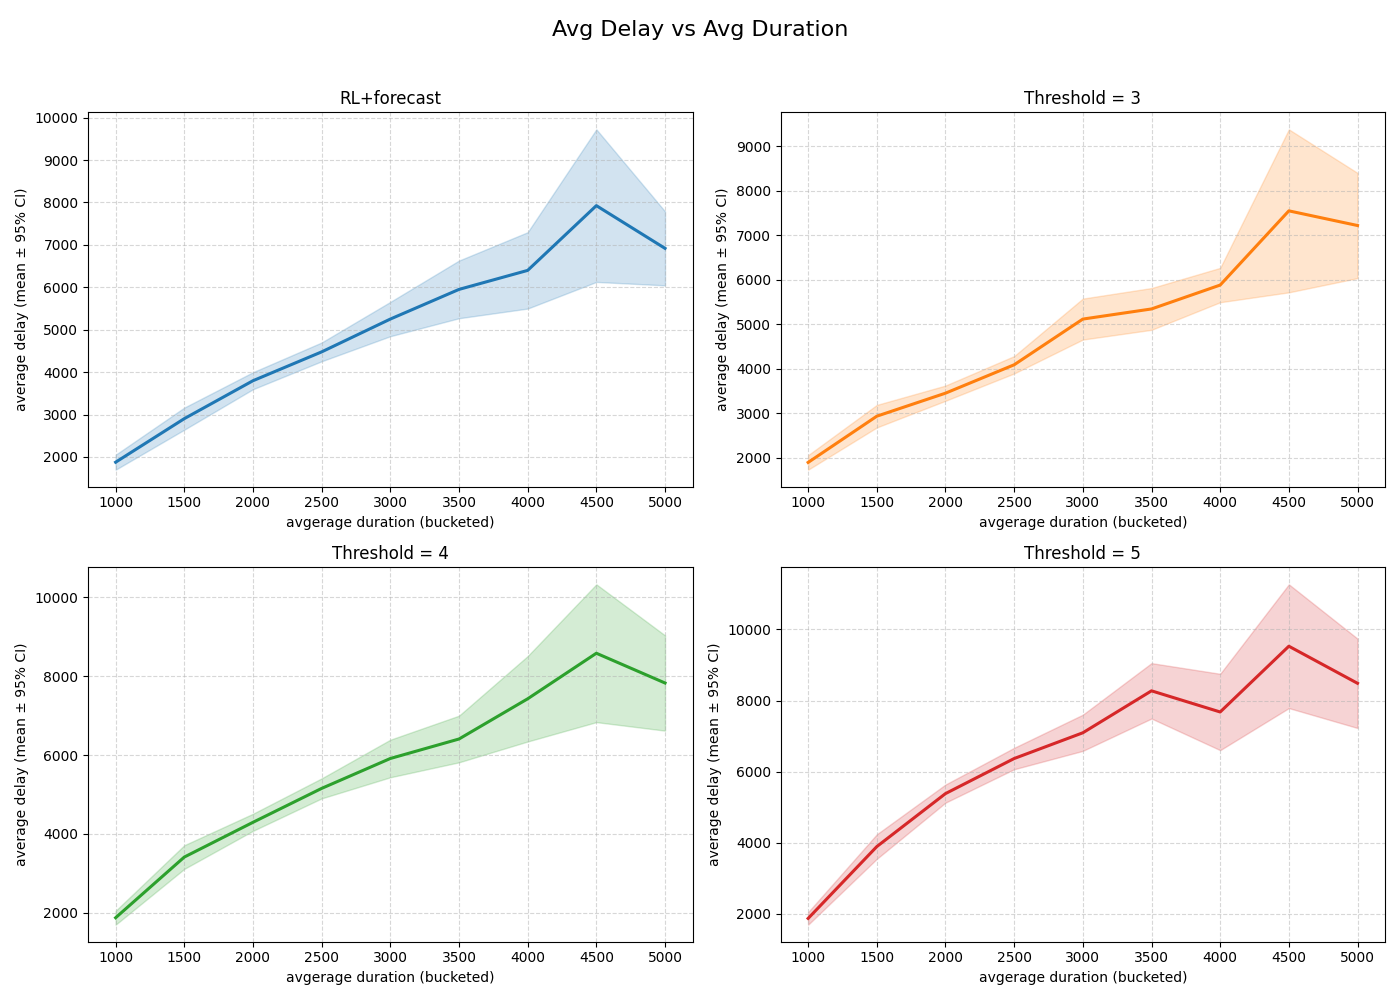

In [54]:
# 参数设置
bucket_size = 500
min_duration = 1000
max_duration = 5500


# 创建子图画布
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()  # 展平成一维索引

for idx, model in enumerate(model_dirs):
    all_duration = []
    all_delay = []

    for i in range(20):
        file_path = os.path.join(model, f'test_{i}.csv')
        df = pd.read_csv(file_path)

        durations = pd.to_numeric(df['avg_duration'], errors='coerce')
        delays = pd.to_numeric(df['avg_delay'], errors='coerce')

        valid = (
            durations.notna() &
            delays.notna() &
            (durations >= min_duration) &
            (durations <= max_duration)
        )
        durations = durations[valid]
        delays = delays[valid]

        all_duration.extend(durations.tolist())
        all_delay.extend(delays.tolist())

    df_model = pd.DataFrame({'duration': all_duration, 'delay': all_delay})
    df_model['bucket'] = (df_model['duration'] // bucket_size) * bucket_size
    grouped = df_model.groupby('bucket')['delay'].agg(['mean', 'std', 'count']).reset_index()
    grouped['ci95'] = 1.96 * grouped['std'] / np.sqrt(grouped['count'])

    # 当前子图
    ax = axs[idx]
    ax.plot(grouped['bucket'], grouped['mean'],
            label=labels[idx],
            color=colors[idx],
            linewidth=2.2)

    ax.fill_between(grouped['bucket'],
                    grouped['mean'] - grouped['ci95'],
                    grouped['mean'] + grouped['ci95'],
                    alpha=0.2,
                    color=colors[idx])

    # 坐标轴 & 样式
    ax.set_title(labels[idx])
    ax.set_xlabel('avgerage duration (bucketed)')
    ax.set_ylabel('average delay (mean ± 95% CI)')
    ax.grid(True, linestyle='--', alpha=0.5)

# 调整布局
plt.suptitle('Avg Delay vs Avg Duration', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()